In [17]:
import csv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import networkx as nx
from pprint import pprint
from collections import defaultdict
import os
from pathlib import Path, PosixPath
import math
import matplotlib.colors as clr


In [4]:
import sys
sys.path.insert(0, '/Users/hirokihanada/code/src/github.com/hanapedia/chaos-experiments/tracerca_experiment/experiments/train-ticket/files')
from analysis import TraceRcaAnalysis

In [46]:
class TraceRcaAnalysisVisualize(TraceRcaAnalysis):
    HISTORICAL_NODE_COLS = ['num_in','num_out','weight_in','weight_out','num_traces','num_unique_traces']
    NODE_COLS = ['num_in', 'num_out', 'weight_in', 'weight_out', 'num_anomalous_in', 'num_anomalous_out', 'weight_anomalous_in', 'weight_anomalous_out', 'num_traces', 'num_anomalous_traces', 'num_unique_traces', 'num_unique_anomalous_traces']
    TOPOLOGY_COLS = ['num_nodes', 'num_edges', 'num_anomalous_edges', 'weight_edges', 'weight_anomalous_edges', 'num_traces', 'num_unique_traces', 'num_unique_anomalous_traces']
    LOW_ACC_COLOR = 'orangered'
    NORMAL_COLOR = 'mediumaquamarine'

    # tests
    def _dataframe_index_test(self):
        idx = pd.IndexSlice
        vals=self.df.loc[idx['admin-order', 'abort', '1011', :],'num_in'].values
        print(vals)
    # load dataframes generated by traceRcaAnalysis
    def load_dataframe(self, input_file: Path | PosixPath):
        if type(input_file) not in (Path, PosixPath):
            raise Exception('input_file must be of type Path')

        df: pd.DataFrame = self.load_pickle_file(input_file)
        return df


    # load dataframes generated by traceRcaAnalysis
    def load_low_accuracy_results(self, input_file: Path | PosixPath):
        if type(input_file) not in (Path, PosixPath):
            raise Exception('input_file must be of type Path')

        low_accu_faults: list = self.load_pickle_file(input_file)
        return low_accu_faults

    def load_df_and_divide(self, df_file='', la_file=''):
        # input type check
        if not df_file: 
            df_file = self.output_path / 'node_df.pkl'
        elif type(df_file) not in (Path, PosixPath):
            raise Exception('input_file must be of type Path')

        if not la_file: 
            la_file = self.output_path / 'low_accuracy.pkl'
        elif type(la_file) not in (Path, PosixPath):
            raise Exception('input_file must be of type Path')

        # load dataframe and low acc file
        df = self.load_dataframe(df_file)
        low_acc_results = self.load_low_accuracy_results(la_file)

        # divide dataframe into noraml and low accuracy data 
        idx = pd.IndexSlice
        la_df = pd.DataFrame()
        if len(df.index.names) != 4:
            la_df = df.loc[df['localizedat'] != '1']
        for fault_name in low_acc_results:
            indice = fault_name.split('_')
            if len(df.index.names) == 4:
                _la_df = df.loc[idx[indice[0],indice[1],indice[2],:], :]
                la_df = pd.concat([la_df, _la_df] )

            df = df.drop(idx[indice[0],indice[1],indice[2]])
        return df, la_df

    # get a list of colors for each bar in bar graphs 
    # if the fault in question had low accuracy, the bar will be colored accordingly
    def get_colors_list(self, df):
        # load low_accuracy data 
        # set color for bars
        la_file = self.output_path / 'low_accuracy.pkl'
        low_acc_results = self.load_low_accuracy_results(la_file)
        if len(df.index.names) == 1:
            low_acc_results = list(map(lambda x: x.split('_')[0], low_acc_results))
        else:
            low_acc_results = list(map(lambda x: tuple(x.split('_')), low_acc_results))
        colors = []
        for node in df.index.values:
            if node in low_acc_results:
                colors.append(self.LOW_ACC_COLOR)
            else:
                colors.append(self.NORMAL_COLOR)
        return colors 

    # aggregate node data per column (root cause serivces / sum of all services)
    def aggregate_node_data(self, df: pd.DataFrame):
        def map_to_dict(map_dict: dict, column_names: list, new_entries: list):
            for cn, ne in zip(column_names, new_entries):
                map_dict[cn].append(ne)
            return map_dict

        # prepare partial index
        reduced_idx = df.index.droplevel('node')
        index_names = reduced_idx.names
        reduced_idx = list(set(reduced_idx))

        # aggregate into new dataframe
        idx = pd.IndexSlice
        self.NODE_COLS = df.columns
        df_dict = defaultdict(list)
        for fault_idx in reduced_idx:
            fault_idx = list(fault_idx)
            _df = df.loc[idx[fault_idx[0],fault_idx[1],fault_idx[2],:],self.NODE_COLS]
            new_row = df.loc[idx[fault_idx[0],fault_idx[1],fault_idx[2],fault_idx[0]],self.NODE_COLS] 
            new_row = list(new_row.divide(_df.sum(axis=0)).values)
            df_dict = map_to_dict(df_dict, index_names, fault_idx)
            df_dict = map_to_dict(df_dict, self.NODE_COLS, new_row)
            # new_row = list(fault_idx).extend(list(new_row))
            # aggr_df.loc[fault_idx[0],fault_idx[1],fault_idx[2]] = new_row
        aggr_df = pd.DataFrame.from_dict(df_dict)
        aggr_df.set_index(index_names)
        return aggr_df

    # reduce node data to only rows for root cause services
    def reduce_node_df(self, df: pd.DataFrame):
        reduced_index_names = df.index.names[:3]
        cols = list(reduced_index_names) + list(df.columns)
        _df = pd.DataFrame(columns=cols)
        for indice in df.index:
            if indice[0] != indice[3]:
                continue
            new_row = [indice[0],indice[1],indice[2]] + list(df.loc[indice[0],indice[1],indice[2],indice[0]])
            _df.loc[len(_df)] = new_row
        _df = _df.set_index(reduced_index_names)
        return _df

    # Add new columns to dataframe for topology data
    def add_topology_columns(self, df: pd.DataFrame):
        # calculate the values for the new columns
        ano_edge_ratio = self.get_cols_ratio((df, 'num_anomalous_edges'), (df, 'num_edges'))
        ano_edge_weight_ratio = self.get_cols_ratio((df, 'weight_anomalous_edges'), (df, 'weight_edges')) 
        ano_trace_ratio = self.get_cols_ratio((df, 'num_anomalous_traces'), (df, 'num_traces')) 
        ano_unique_trace_ratio = self.get_cols_ratio((df, 'num_unique_anomalous_traces'), (df, 'num_unique_traces')) 

        df = df.assign(anomalous_edge_ratio=ano_edge_ratio, anomalous_edge_weight_ratio=ano_edge_weight_ratio, anomalous_trace_ratio=ano_trace_ratio, anomalous_unique_trace_ratio=ano_unique_trace_ratio)
        return df

    # create new df with combined data
    def create_combined_df(self, topology_df: pd.DataFrame, node_df: pd.DataFrame) -> pd.DataFrame:
        nt_tt_ratio = self.get_cols_ratio(col_n=(node_df, 'num_traces'),col_d=(topology_df, 'num_traces'))
        nt_tat_ratio = self.get_cols_ratio(col_n=(node_df, 'num_traces'),col_d=(topology_df, 'num_anomalous_traces'))
        nat_tat_ratio = self.get_cols_ratio(col_n=(node_df, 'num_anomalous_traces'),col_d=(topology_df, 'num_anomalous_traces'))
        nat_nt_ratio = self.get_cols_ratio(col_n=(node_df, 'num_anomalous_traces'),col_d=(node_df, 'num_traces'))

        # trace ratios
        node_df = node_df.assign(node_trace_topo_trace_ratio=nt_tt_ratio, node_trace_topo_ano_trace_ratio=nt_tat_ratio, node_ano_trace_topo_ano_trace_ratio=nat_tat_ratio, node_ano_trace_node_trace_ratio=nat_nt_ratio)

        nwi_twi_ratio = self.get_cols_ratio(col_n=(node_df, 'weight_in'),col_d=(topology_df, 'weight_edges'))
        nwi_twai_ratio = self.get_cols_ratio(col_n=(node_df, 'weight_in'),col_d=(topology_df, 'weight_anomalous_edges'))
        nwai_twai_ratio = self.get_cols_ratio(col_n=(node_df, 'weight_anomalous_in'),col_d=(topology_df, 'weight_anomalous_edges'))
        nwai_nwi_ratio = self.get_cols_ratio(col_n=(node_df, 'weight_anomalous_in'),col_d=(node_df, 'weight_in'))
        nwo_two_ratio = self.get_cols_ratio(col_n=(node_df, 'weight_out'),col_d=(topology_df, 'weight_edges'))
        nwo_twao_ratio = self.get_cols_ratio(col_n=(node_df, 'weight_out'),col_d=(topology_df, 'weight_anomalous_edges'))
        nwao_twao_ratio = self.get_cols_ratio(col_n=(node_df, 'weight_anomalous_out'),col_d=(topology_df, 'weight_anomalous_edges'))
        nwao_nwo_ratio = self.get_cols_ratio(col_n=(node_df, 'weight_anomalous_out'),col_d=(node_df, 'weight_out'))

        # edge weight ratios
        node_df = node_df.assign(node_in_w_topo_edge_w_ratio=nwi_twi_ratio, node_in_w_topo_ano_edge_w_ratio=nwi_twai_ratio, node_ano_in_w_topo_ano_edge_w_ratio=nwai_twai_ratio, node_ano_in_w_node_in_w_ratio=nwai_nwi_ratio)
        node_df = node_df.assign(node_out_w_topo_edge_w_ratio=nwo_two_ratio, node_out_w_topo_ano_edge_w_ratio=nwo_twao_ratio, node_ano_out_w_topo_ano_edge_w_ratio=nwao_twao_ratio, node_ano_out_w_node_out_w_ratio=nwao_nwo_ratio)

        new_cols = node_df.columns[-12:]
        return node_df.loc[:, new_cols]
    # return the ratio of two arbitrary columns as a numpty ndarray
    def get_cols_ratio(self, col_n: tuple, col_d: tuple):
        return col_n[0].loc[:, col_n[1]] / col_d[0].loc[:, col_d[1]]

    # get columns with non-zero values
    def get_columns(self, df: pd.DataFrame):
        cols = df.any(axis=0)
        cols = [k for k,v in cols.items() if v]
        # ignore index cols
        return cols[3:]

    # get subplot grid axes
    def get_subplot(self, nrows, ncols=2, ax_w_unit=13, ax_h_unit=11) -> plt.Axes:
        fig_size = [ncols*ax_w_unit,nrows*ax_h_unit]
        
        return plt.subplots(nrows, ncols, figsize=fig_size, squeeze=False, layout='tight')


    # draw bar graph
    def draw_bar(self, df: pd.DataFrame, **kwargs):
        try:
            df.plot.bar(**kwargs)
        except:
            pass

    # draw histogram
    def draw_histogram(self, data_normal: list, data_la: list, ax: plt.Axes, **kwargs):
        try:
            la_color = clr.to_rgba(self.LOW_ACC_COLOR, 0.7)
            ax.hist(data_normal, bins='auto', color=self.NORMAL_COLOR, **kwargs)
            ax.hist(data_la, bins='auto', color=la_color, **kwargs)
        except:
            pass

    # draw histogram
    def draw_ecdf(self, data_normal: list, data_la: list, ax: plt.Axes, **kwargs):
        la_color = clr.to_rgba(self.LOW_ACC_COLOR, 0.7)
        ax.hist(data_normal, bins=50, color=self.NORMAL_COLOR, cumulative=True, density=True, histtype='step', linestyle='-', **kwargs)
        ax.hist(data_la, bins=50, color=la_color, cumulative=True, density=True, histtype='step', linestyle='--', **kwargs)
        # labels 
        label_n, = ax.plot([], [],color=self.NORMAL_COLOR, label='high accuracy', linestyle='-', **kwargs)
        label_la, = ax.plot([], [],color=la_color, label='low accuracy', linestyle='--', **kwargs)
        ax.legend(handles=[label_n, label_la],loc='upper left')

    # draw line
    def draw_line(self, ax: plt.Axes, x: list, y: list, **kwargs):
        try:
            ax.plot(x,y, **kwargs)
            pass
        except:
            pass

    # draw graphs
    def draw_graphs_and_save(self, title_prefix: str, **kwargs):
        if 'df' not in kwargs:
            raise Exception('Provide at least one dataframe')
        df = kwargs['df']

        la_df = pd.DataFrame()
        colors = []
        if 'la_df' in kwargs:
            la_df = kwargs['la_df']
        else:
            colors = self.get_colors_list(df=df)

        ncols = 2
        if 'ncols' in kwargs:
            ncols = kwargs.ncols
            
        cols = df.columns
        if 'root_cause_service' in cols:
            cols = self.get_columns(df)

        # get subplots
        nrows = math.ceil(len(cols)/ncols)
        axes = self.get_subplot(nrows, ncols)
        for i, col in enumerate(cols):
            ax = axes[math.floor(i / ncols), i % ncols]
            ax.set_title(f'{title_prefix} {col}')
            if 'la_df' in kwargs:
                data_normal = df.loc[:, col].values
                data_la = la_df.loc[:, col].values
                self.draw_ecdf(data_normal=data_normal, data_la=data_la, ax=ax)
            else:
                df = df.sort_values(by=col)
                ax.tick_params(labelsize=6)
                self.draw_bar(df=df, color=colors, ax=ax, y=col, title=f'{title_prefix}: {col}')

        # plt.savefig(self.output_path/f'{title_prefix}.svg')



In [20]:
trav = TraceRcaAnalysisVisualize(experiment_name='microservice_faults_filtered', output="./data/train-ticket")

In [ ]:
# bar graph with each bar representing each node, services with low accuracy visualized
# data: historical node data
# columns:
    # num in 
    # num out 
    # num weight in
    # num weight out
    # num traces
    # num unique traces
    # divide by total num when comparing with other dataset * low priority *
        # num weight in / num total weight
        # num weight out / num total weight
        # etc
# color low accuracy services
def historical_node_bar_graph(self):
    # load dataframe  
    # drop unnecessary indexes 
    df_file = self.output_path / 'historical_node_df.pkl'
    df = self.load_dataframe(df_file)
    df = df.reset_index(level=[0,1,2])

    self.draw_graphs_and_save(title_prefix='historical_node_bar', df=df)

historical_node_bar_graph(trav)

In [ ]:
# histogram of aggeregated data from each fault
# data: injected node data aggregated by faults 
# columns: of root cause service
    # num in / total edges
    # num out / total edges 
    # num weight in / total weight 
    # num weight out / total weight 
    # num traces / total traces 
    # num unique traces / total unique traces
    # num anomalous in / total anomalous in
    # num anomalous out / total anomalous out
    # num weight anomalous in / total weight anomalous in
    # num weight anomalous out / total weight anomalous out 
    # num anomalous traces / total anomalous traces
    # num anomalous unique traces / tota anomalous unique traces
def node_aggregated_histogram(trav):
    # prepare data 
    df, la_df = trav.load_df_and_divide()
    df = trav.aggregate_node_data(df)
    la_df = trav.aggregate_node_data(la_df)

    trav.draw_graphs_and_save(title_prefix='node_hist', df=df, la_df=la_df)

node_aggregated_histogram(trav)

In [ ]:
# bar graph of data from each topology
# data: injected and historical topology data
# columns: 
    # num nodes
    # num edges
    # num anomalous edges
    # num anomalous edges / num edges
    # weight edges
    # weight anomalous edges
    # weight anomalous edges / weight edges
    # num traces
    # num anomalous traces
    # num anomalous traces / num traces
    # num unique traces
    # num unique anomalous traces
    # num unique anomalous traces / num unique traces
def topology_bar_graph(trav):
    # load dataframe  
    # drop unnecessary indexes 
    # add new columns anomalous_edge_ratio, weight_anomalous_edge_ratio, anomalous_trace_ratio, anomalous_unique_trace_ratio
    df_file = trav.output_path / 'topology_df.pkl'
    df = trav.load_dataframe(df_file)
    df = trav.add_topology_columns(df)

    trav.draw_graphs_and_save(title_prefix='topology_bar', df=df)

topology_bar_graph(trav)

In [ ]:
# histograms of combined data
# data: injected node data and injected topology data 
# columns: 
    # ratio of traces that passes through the root cause and total number of traces
        # node: num traces
        # topology: num traces
    # ratio of anomalous traces that passes through the root cause and total number of anomalous traces
        # node: anomalous num traces
        # topology: anomalous num traces
    # ratio of traces that passes through the root cause and total number of traces that passes through the root cause
        # node: num anomalous traces, num traces
def combined_data_histogram(trav):
    # load topology dataframe and divide
    topology_df_file = trav.output_path / 'topology_df.pkl'
    topology_df, la_topology_df = trav.load_df_and_divide(df_file=topology_df_file)
    # load node dataframe and divide, then reduce
    node_df_file = trav.output_path / 'node_df.pkl'
    node_df, la_node_df = trav.load_df_and_divide(df_file=node_df_file)
    node_df = trav.reduce_node_df(node_df)
    la_node_df = trav.reduce_node_df(la_node_df)

    # compute ratios and create new dataframes
    combined_df = trav.create_combined_df(topology_df=topology_df, node_df=node_df)
    la_combined_df = trav.create_combined_df(topology_df=la_topology_df, node_df=la_node_df)

    trav.draw_graphs_and_save(title_prefix='combined_hist', df=combined_df, la_df=la_combined_df)

combined_data_histogram(trav)

In [25]:
# plot of cpu data during cpu anomaly injection 
# data: timestamped cpu data from low accuracy cpu anomaly injected invocation data
# each line / scatter plot represents cpu data form each services that had cpu anomalies 
def cpu_line_graph(trav):
    # load timestamped cpu data 
    cpu_df_file = trav.output_path / 'timestamped_cpu_data.pkl'
    cpu_df = trav.load_dataframe(cpu_df_file)

    idx = pd.IndexSlice
    indexes = list(set(cpu_df.index))
    # get subplots
    ncols = 2
    nrows = math.ceil(len(indexes)/ncols)
    axes = trav.get_subplot(nrows, ncols)
    for i, indice in enumerate(indexes):
        ax = axes[math.floor(i / ncols), i % ncols]
        ax.set_title(f'cpu anomalous usage: {indice}')
        ax.set_ylim([0,1.25])

        _cpu_df = cpu_df.loc[indice]
        _cpu_df = _cpu_df.set_index('target')
        _cpu_df = _cpu_df.sort_values(by='med_timestamp')
        targets = list(set(_cpu_df.index))
        for target in targets:
            x = _cpu_df.loc[target, 'med_timestamp'].values
            y = _cpu_df.loc[target, 'cpu_use'].values
            trav.draw_line(ax=ax, x=x, y=y, label=target, marker='o')
        ax.legend(loc='best') 
        # pprint(_cpu_df.sort_values(by='med_timestamp'))
    plt.savefig(trav.output_path/f'cpu_line.svg')

In [26]:
# draw figure for paper
# only anomalous edge in to total anomalous edge ratio
def draw_figure1(trav):
    # load topology dataframe and divide
    topology_df_file = trav.output_path / 'topology_df.pkl'
    topology_df, la_topology_df = trav.load_df_and_divide(df_file=topology_df_file)
    # load node dataframe and divide, then reduce
    node_df_file = trav.output_path / 'node_df.pkl'
    node_df, la_node_df = trav.load_df_and_divide(df_file=node_df_file)
    node_df = trav.reduce_node_df(node_df)
    la_node_df = trav.reduce_node_df(la_node_df)

    # compute ratios and create new dataframes
    combined_df = trav.create_combined_df(topology_df=topology_df, node_df=node_df)
    la_combined_df = trav.create_combined_df(topology_df=la_topology_df, node_df=la_node_df)

    # fm.fontManager.addfont('./files/MS Mincho.ttf')
    font_size = 36
    # font_family = 'MS Mincho'
    line_width = 5

    x_label = 'Ratio of Number of Anomalous Traces Through Root Cause \nand Number of Total Anomalous Traces'
    y_label = 'Frequency'
    col_name = 'node_ano_trace_topo_ano_trace_ratio'
    file_name = 'trace_rate_big.png'

    dpi = 100
    _ = plt.figure(figsize=[16,9], dpi=dpi)
    ax: plt.Axes = plt.gca() 

    plt.rcParams['font.size'] = font_size
    # plt.rcParams['font.family'] = font_family
    plt.rcParams['font.weight'] = 'bold'
    # plt.xlabel(x_label, fontdict={'size': font_size, 'family': font_family})
    # plt.ylabel(y_label, fontdict={'size': font_size, 'family': font_family})
    # plt.xticks(fontsize=font_size, fontfamily=font_family)
    # plt.yticks(fontsize=font_size, fontfamily=font_family)
    plt.xlabel(x_label, fontdict={'size': font_size})
    plt.ylabel(y_label, fontdict={'size': font_size})
    plt.xticks(fontsize=font_size)
    plt.yticks(fontsize=font_size)

    data_normal = combined_df.loc[:,col_name].values
    data_la = la_combined_df.loc[:,col_name].values
    trav.draw_ecdf(data_normal=data_normal, data_la=data_la, ax=ax, linewidth=line_width,)
    plt.savefig(trav.output_path/file_name, bbox_inches="tight")

In [146]:
# draw graphs for paper
def draw_ecdfs_for_paper(title_prefix: str, df, la_df):
    ncols = 2
    fontsize = 16
    
    plt.rcParams['font.family'] = "Times New Roman"
    plt.rcParams['font.size'] = fontsize


    # get subplots
    ncols=4
    nrows=3
    ax_w_unit=8
    ax_h_unit=5
    fig_size = [ncols*ax_w_unit,nrows*ax_h_unit]
    fig, axes = plt.subplots(nrows, ncols, figsize=fig_size, layout="tight")
    
    fig.suptitle("Service level characteristics for low accuracy and high accuracy injections", fontsize=24)
    
    cols = {
        "num_in": "Number of inward edges",
        "num_out": "Number of outward edges",
        "weight_in": "Number of occurences for inward edges",
        "weight_out": "Number of occurences for outward edges",
        "num_anomalous_in": "Number of anomalous inward edges",
        "num_anomalous_out": "Number of anomalous outward edges",
        "weight_anomalous_in": "Number of occurences for anomalous inward edges",
        "weight_anomalous_out": "Number of occurences for anomalous outward edges",
        "num_traces": "Number of traces",
        "num_anomalous_traces": "Number of anomalous traces",
        "num_unique_traces": "Number of unique trace patterns",
        "num_unique_anomalous_traces": "Number of unique anomalous trace patterns",
    }
    
    x_label = "Ratio"
    y_label = "Cumulative frequency"
    
    xticks = [0.25, 0.5, 0.75]
    yticks = [0, 0.25, 0.5, 0.75, 1.0]

    LOW_ACC_COLOR = 'orangered'
    NORMAL_COLOR = 'mediumaquamarine'
    la_color = clr.to_rgba(LOW_ACC_COLOR, 0.7)

    linewidth = 5
    
    for i, col in enumerate(cols.keys()):
        ax = axes[math.floor(i / ncols), i % ncols]
        ax.set_title(f"{i+1}. {cols[col]}")
        ax.set_xlabel(x_label, fontdict={'size': fontsize})
        ax.set_ylabel(y_label, fontdict={'size': fontsize})
        # ax.set_xticks(xticks, fontsize=fontsize)
        ax.set_yticks(yticks, fontsize=fontsize)
        
        data_normal = df.loc[:, col].values
        data_la = la_df.loc[:, col].values
        ax.hist(data_normal, bins=50, color=NORMAL_COLOR, cumulative=True, density=True, histtype='step', linestyle='-', linewidth=linewidth)
        ax.hist(data_la, bins=50, color=la_color, cumulative=True, density=True, histtype='step', linestyle='--', linewidth=linewidth)

    label_n, = ax.plot([], [],color=NORMAL_COLOR, label='high accuracy', linestyle='-', linewidth=linewidth)
    label_la, = ax.plot([], [],color=la_color, label='low accuracy', linestyle='--', linewidth=linewidth)
    fig.legend(handles=[label_n, label_la],loc='lower center', ncols=2,bbox_to_anchor=(0.5, -0.02))
            
    plt.savefig("./5-6_trainticket.png", bbox_inches="tight")


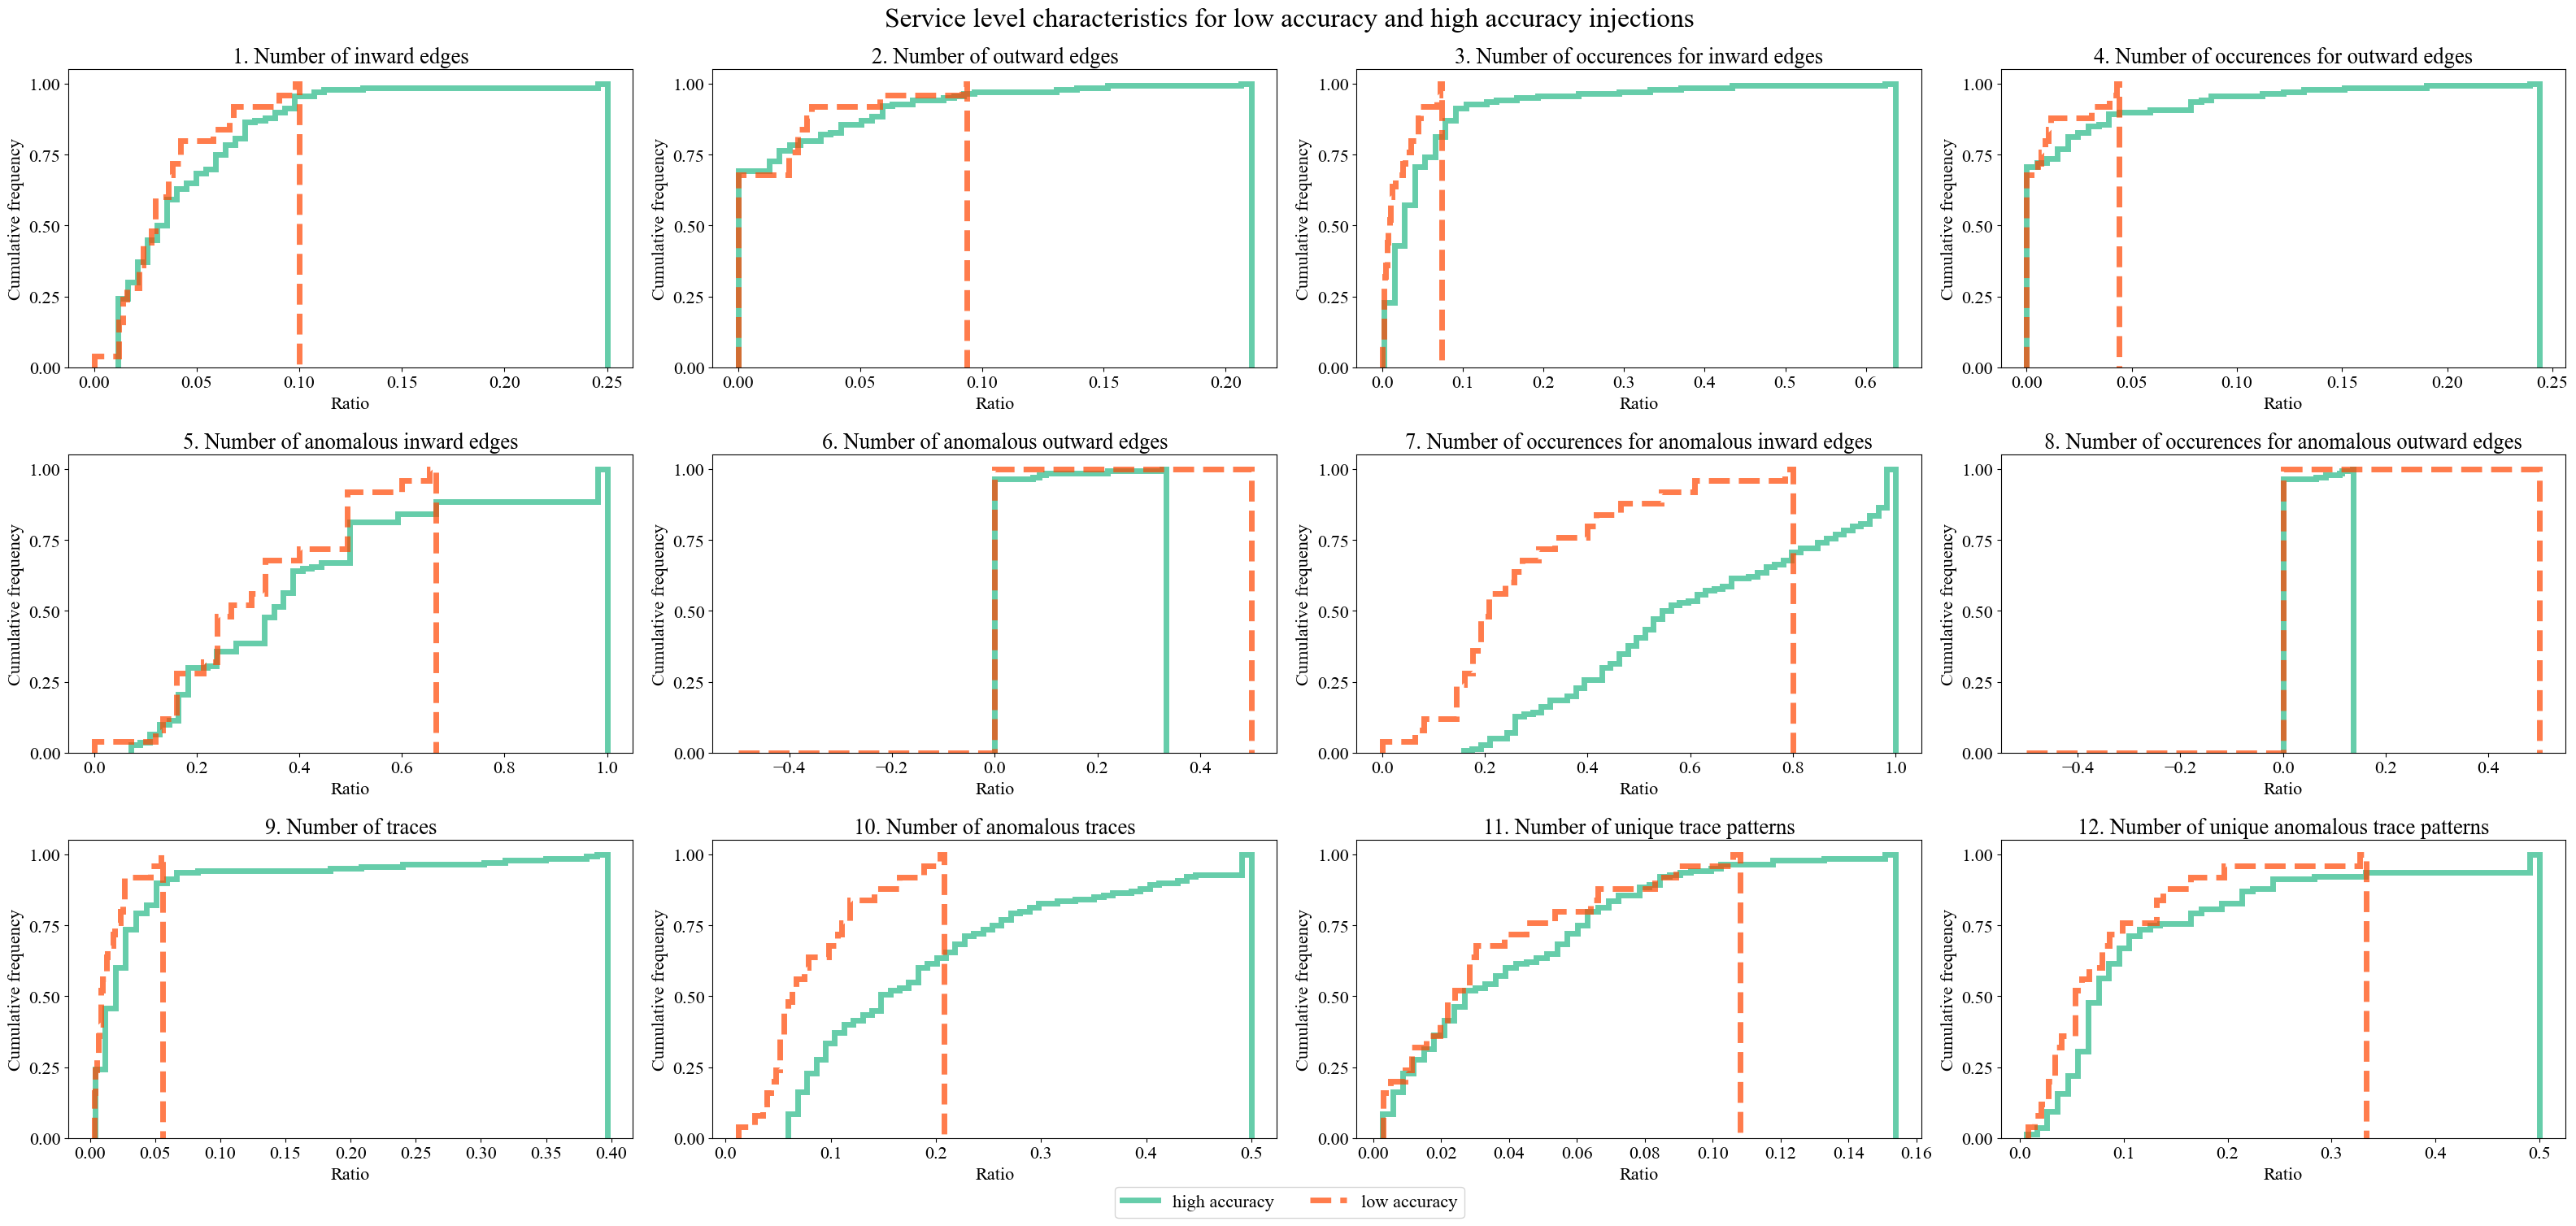

In [147]:
# histogram of aggeregated data from each fault
# data: injected node data aggregated by faults 
# columns: of root cause service
    # num in / total edges
    # num out / total edges 
    # num weight in / total weight 
    # num weight out / total weight 
    # num traces / total traces 
    # num unique traces / total unique traces
    # num anomalous in / total anomalous in
    # num anomalous out / total anomalous out
    # num weight anomalous in / total weight anomalous in
    # num weight anomalous out / total weight anomalous out 
    # num anomalous traces / total anomalous traces
    # num anomalous unique traces / tota anomalous unique traces
def node_aggregated_histogram(trav):
    # prepare data 
    df, la_df = trav.load_df_and_divide()
    df = trav.aggregate_node_data(df)
    la_df = trav.aggregate_node_data(la_df)

    draw_ecdfs_for_paper(title_prefix='node_hist', df=df, la_df=la_df)

node_aggregated_histogram(trav)